*Extra analysis performed utilizing the gtfs-kit library*. In particular, mapping the possible routes of a service. 

gtfs-kit
- [Documentation](https://mrcagney.github.io/gtfs_kit_docs/index.html)
- [Github](https://github.com/mrcagney/gtfs_kit/tree/master)
- [more gtfs links](https://gtfs.org/resources/visualizations/)

# Imports/Installation

In [1]:
import gtfs_kit as gk
import pandas as pd 
import folium
from geodatasets import get_path
import shapely
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.cm import tab20
import matplotlib.cm as cm
import matplotlib.colors as mcolors
mpl.rcParams['figure.dpi'] = 150

In [2]:
# Functions
def collect_shape_ids_for_route(feed, service: str):
    week = feed.get_first_week()
    dates = [week[4], week[5], week[6]]  # First Friday, Saturday & Sunday
    route_timetables = feed.build_route_timetable(service, dates)
    unique_shape_ids = route_timetables.drop_duplicates(subset=['route_id', 'service_id', 'shape_id'])
    # getting all routes in a dictionary
    shape_dict = {x: None for x in sorted(unique_shape_ids['shape_id'].unique())}
    for shape in shape_dict.keys():
        shape_id_example = unique_shape_ids[unique_shape_ids['shape_id']==shape]['trip_id']
        plot = feed.map_trips(trip_ids=shape_id_example, show_stops=True, show_direction=True)
        shape_dict[shape] = plot
    return shape_dict

def display_gk_plot(plot):
    fig = folium.Figure(width=800, height=500)
    fig.add_child(plot)
    return fig

def find_stop_pattern_variations_count(feed, trip_stats: pd. DataFrame, route_name: str):
    stop_name_dict = dict(zip(feed.stops['stop_id'], feed.stops['stop_name']))
    stop_pattern_count_df = pd.DataFrame(trip_stats[(trip_stats['route_id']=='5')].groupby('stop_pattern_name')['duration'].count()).reset_index().sort_values(by='duration', ascending=False)
    stop_pattern_variations_count_df = trip_stats[(trip_stats['route_id']=='5')].drop_duplicates(subset=['route_id', 'shape_id'])
    stop_pattern_variations_count_df['start_stop_id'] = stop_pattern_variations_count_df['start_stop_id'].replace(stop_name_dict)
    stop_pattern_variations_count_df['end_stop_id'] = stop_pattern_variations_count_df['end_stop_id'].replace(stop_name_dict)
    stop_pattern_variations_count_df = stop_pattern_variations_count_df.drop(columns=['trip_id', 'route_short_name', 'route_type', 'start_time', 'end_time', 'is_loop'])
    stop_pattern_variations_count_df = stop_pattern_variations_count_df.sort_values(by='start_stop_id')
    stop_pattern_name_dict = dict(zip(stop_pattern_count_df['stop_pattern_name'], stop_pattern_count_df['duration']))
    stop_pattern_variations_count_df['count_per_day'] = stop_pattern_variations_count_df['stop_pattern_name'].replace(stop_pattern_name_dict)
    return stop_pattern_variations_count_df

In [3]:
path_to_file = get_path('nybb')
boros = gpd.read_file(path_to_file).to_crs(epsg=3857)
boros = boros[boros['BoroName']!='Staten Island']

In [4]:
orig_stations_df = pd.read_csv("../data/MTA_Subway_Stations_20240325.csv")
orig_stations_df = orig_stations_df[orig_stations_df['Borough']!='SI'] 
orig_stations_df = orig_stations_df.drop(columns=['Division', 'ADA', 'ADA Northbound', 'ADA Southbound', 'ADA Notes'
                                                , 'North Direction Label', 'South Direction Label'])

In [5]:
orig_stations_df['GTFS Latitude'] = [x.split(" ")[1][1:] for x in orig_stations_df['Georeference']]
orig_stations_df['GTFS Longitude'] = [x.split(" ")[2][:-1] for x in orig_stations_df['Georeference']]
geometries = [shapely.Point(x,y) for x,y in list(zip(orig_stations_df['GTFS Latitude'], orig_stations_df['GTFS Longitude']))]
orig_stations_df['geometry'] = geometries
orig_stations_gdf = gpd.GeoDataFrame(orig_stations_df)
orig_stations_gdf = orig_stations_gdf.dissolve(by='Complex ID').reset_index()
orig_stations_gdf['geometry'] = orig_stations_gdf.geometry.centroid
orig_stations_gdf = orig_stations_gdf.set_crs(epsg=4326).to_crs(epsg=3857)
orig_stations_gdf = orig_stations_gdf.sort_values(by='Complex ID')

In [6]:
orig_stations_gdf

,Complex ID,geometry,GTFS Stop ID,Station ID,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,Georeference
0,1,POINT (-8227849.988 4979215.939),R01,1,Astoria,Astoria-Ditmars Blvd,Q,N W,Elevated,-73.912034,40.775036,POINT (-73.912034 40.775036)
1,2,POINT (-8228496.643 4978513.603),R03,2,Astoria,Astoria Blvd,Q,N W,Elevated,-73.917843,40.770258,POINT (-73.917843 40.770258)
2,3,POINT (-8228901.401 4978002.243),R04,3,Astoria,30 Av,Q,N W,Elevated,-73.921479,40.766779,POINT (-73.921479 40.766779)
3,4,POINT (-8229349.907 4977273.391),R05,4,Astoria,Broadway,Q,N W,Elevated,-73.925508,40.76182,POINT (-73.925508 40.76182)
4,5,POINT (-8229802.644 4976536.218),R06,5,Astoria,36 Av,Q,N W,Elevated,-73.929575,40.756804,POINT (-73.929575 40.756804)
...,...,...,...,...,...,...,...,...,...,...,...,...
419,628,POINT (-8238514.869 4969673.408),M22,106,Jamaica,Fulton St,M,J Z,Subway,-74.007582,40.710374,POINT (-74.007582 40.710374)
420,629,POINT (-8232170.576 4970163.735),L10,121,Canarsie,Lorimer St,Bk,L,Subway,-73.950275,40.714063,POINT (-73.950275 40.714063)
421,630,POINT (-8227844.589 4968136.427),M08,112,Myrtle Av,Myrtle-Wyckoff Avs,Bk,M,Elevated,-73.912385,40.69943,POINT (-73.912385 40.69943)
422,635,POINT (-8239126.096 4968570.401),R27,23,Broadway,Whitehall St-South Ferry,M,R W,Subway,-74.012994,40.703087,POINT (-74.012994 40.703087)


# Using the Library


### Cleaning the Feed

In [7]:
path = "../data/google_transit"
# removing some rows with null start times
orig_feed = gk.read_feed(path, dist_units='mi')
feed = gk.miscellany.create_shapes(orig_feed, all_trips=True) 
feed.describe()
orig_stops = feed.stops

In [8]:
# removing some rows with null start times
#7 stops are removed, 1 route is removed (I don't see it though...) using feed.clean()
feed = feed.clean()
clean_stops = feed.stops
stop_name_dict = dict(zip(clean_stops['stop_id'], clean_stops['stop_name']))
feed.describe()

,indicator,value
0,agencies,[MTA New York City Transit]
1,timezone,America/New_York
2,start_date,20250811
3,end_date,20251101
4,num_routes,29
5,num_trips,20287
6,num_stops,1488
7,num_shapes,217
8,sample_date,20250814
9,num_routes_active_on_sample_date,29


In [9]:
# all of these stations do not have a location type...
removed_stops = set(orig_stops.stop_id.unique()).difference(set(clean_stops.stop_id.unique()))
# orig_stops[orig_stops['stop_id'].isin(removed_stops)]

In [ ]:
# 217 shape variations!!
feed.trips['shape_id'].nunique()


217

In [11]:
# perfect except for num_stop_time_dists_missing which is because the MTA schedule is precise to only 30 seconds...
# gk.miscellany.assess_quality(feed)

In [12]:
# quick summary of all tables and their columns
gk.miscellany.summarize(feed).head()

,table,column,num_values,num_nonnull_values,num_unique_values,min_value,max_value
0,agency,agency_id,1,1,1,MTA_NYCT,MTA_NYCT
1,agency,agency_name,1,1,1,MTA New York City Transit,MTA New York City Transit
2,agency,agency_url,1,1,1,http://www.mta.info,http://www.mta.info
3,agency,agency_timezone,1,1,1,America/New_York,America/New_York
4,agency,agency_lang,1,1,1,en,en


In [13]:
# Getting the Representative days for the analysis
# note: pre-planned service changes have the correct day (e.g.: New Years Day has Sunday Service)
week = feed.get_first_week()
dates = [week[4], week[5], week[6]]  # First Friday, Saturday & Sunday

### Computing Trip/Route Stats

In [14]:
# for all days
trip_stats = feed.compute_trip_stats()
trip_stats.head().T

,4,312,684,6,314
trip_id,ASP25GEN-1038-Sunday-00_007200_1..N03R,ASP25GEN-1039-Saturday-00_007200_1..N03R,ASP25GEN-1093-Weekday-00_007450_1..N03R,ASP25GEN-1038-Sunday-00_009200_1..N03R,ASP25GEN-1039-Saturday-00_009200_1..N03R
route_id,1,1,1,1,1
route_short_name,1,1,1,1,1
route_type,1,1,1,1,1
direction_id,0,0,0,0,0
shape_id,shape_007,shape_007,shape_007,shape_007,shape_007
stop_pattern_name,0-1,0-1,0-1,0-1,0-1
num_stops,38,38,38,38,38
start_time,01:12:00,01:12:00,01:14:30,01:32:00,01:32:00
end_time,02:10:30,02:10:30,02:12:30,02:30:30,02:30:30


In [15]:
fts = feed.compute_feed_time_series((trip_stats), dates, freq='1h').round(2)
fts

indicator,num_trip_ends,num_trip_starts,num_trips,service_distance,service_duration,service_speed
datetime,,,,,,
2025-08-15 00:00:00,46.0,146.0,175.0,2340.16,154.35,15.16
2025-08-15 01:00:00,121.0,133.0,232.0,1875.52,125.03,15.00
2025-08-15 02:00:00,131.0,130.0,241.0,1742.03,116.58,14.94
2025-08-15 03:00:00,130.0,130.0,240.0,1738.34,116.38,14.94
2025-08-15 04:00:00,129.0,140.0,250.0,1805.22,119.70,15.08
...,...,...,...,...,...,...
2025-08-17 19:00:00,298.0,281.0,534.0,4039.22,249.97,16.16
2025-08-17 20:00:00,274.0,262.0,499.0,3853.03,236.87,16.27
2025-08-17 21:00:00,258.0,245.0,472.0,3691.64,225.43,16.38


## Plots of Service by Day Type

<Axes: xlabel='datetime'>

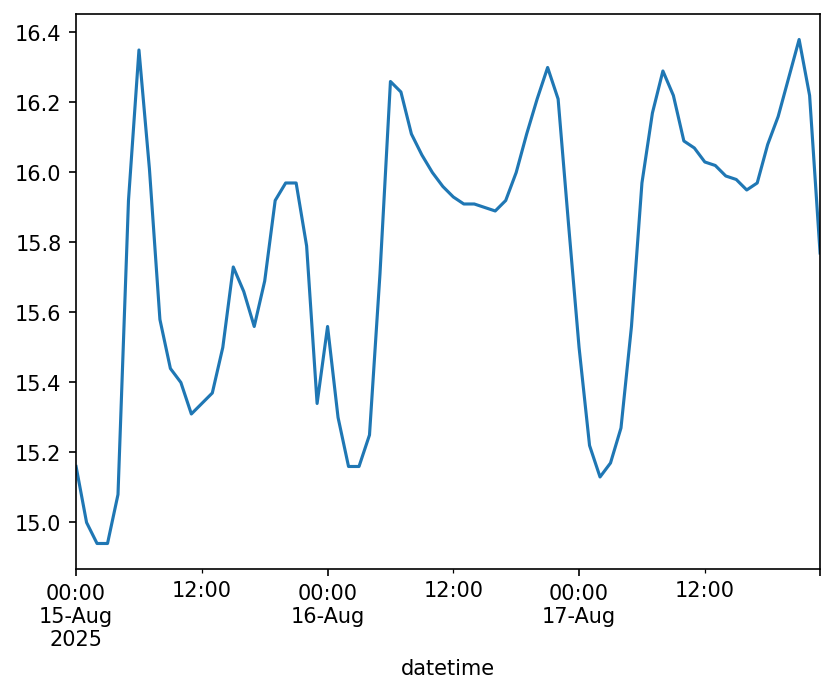

In [16]:
# speed, especially at late nights, depends on how "local" the services are
fts['service_speed'].plot()

<Axes: xlabel='datetime'>

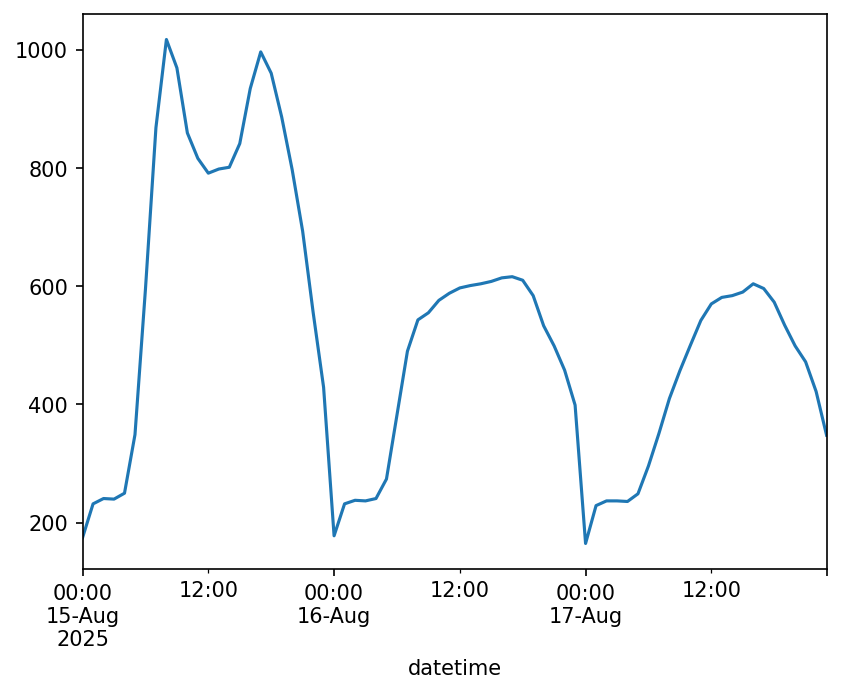

In [17]:
fts['num_trips'].plot()

## Route Timetables

In [18]:
# possible routes feed.routes['route_id'].unique()
route_id = 'L'
route_timetables_L = feed.build_route_timetable(route_id, dates)
route_timetables_L.head()

,route_id,trip_id,service_id,trip_headsign,direction_id,shape_id,stop_id,arrival_time,departure_time,stop_sequence,date
400125,L,BSP25GEN-L049-Weekday-00_000650_L..N01R,Weekday,8 Av,0,shape_175,L29N,00:06:30,00:06:30,1,20250815
400126,L,BSP25GEN-L049-Weekday-00_000650_L..N01R,Weekday,8 Av,0,shape_175,L28N,00:08:00,00:08:00,2,20250815
400127,L,BSP25GEN-L049-Weekday-00_000650_L..N01R,Weekday,8 Av,0,shape_175,L27N,00:10:00,00:10:00,3,20250815
400128,L,BSP25GEN-L049-Weekday-00_000650_L..N01R,Weekday,8 Av,0,shape_175,L26N,00:11:30,00:11:30,4,20250815
400129,L,BSP25GEN-L049-Weekday-00_000650_L..N01R,Weekday,8 Av,0,shape_175,L25N,00:13:00,00:13:00,5,20250815


In [19]:
# getting one trip_id per shape_id
unique_shape_ids = route_timetables_L.drop_duplicates(subset=['route_id', 'shape_id'])
# Getting all Shape IDs in one file 
print(f"There are {route_timetables_L['shape_id'].nunique()} unique routes for the {route_id}")
unique_shape_ids

There are 5 unique routes for the L


,route_id,trip_id,service_id,trip_headsign,direction_id,shape_id,stop_id,arrival_time,departure_time,stop_sequence,date
400125,L,BSP25GEN-L049-Weekday-00_000650_L..N01R,Weekday,8 Av,0,shape_175,L29N,00:06:30,00:06:30,1,20250815
400221,L,BSP25GEN-L049-Weekday-00_005400_L..S01R,Weekday,Canarsie-Rockaway Pkwy,1,shape_172,L01S,00:54:00,00:54:00,1,20250815
400917,L,BSP25GEN-L049-Weekday-00_031950_L..N02R,Weekday,8 Av,0,shape_174,L28N,05:19:30,05:19:30,1,20250815
402011,L,BSP25GEN-L049-Weekday-00_045300_L..S05R,Weekday,Myrtle-Wyckoff Avs,1,shape_171,L01S,07:33:00,07:33:00,1,20250815
402433,L,BSP25GEN-L049-Weekday-00_048750_L..N05R,Weekday,8 Av,0,shape_173,L17N,08:07:30,08:07:30,1,20250815


## Trip Stats

In [20]:
friday = [week[4]]
trip_information_fri = feed.compute_route_stats(trip_stats, friday)
# I don't trust the peak information
trip_information_fri = trip_information_fri.drop(columns=['route_short_name', 'date', 'peak_num_trips', 'is_bidirectional'
                                                          ,'route_type', 'is_loop', 'peak_start_time', 'peak_end_time', 'min_headway'])
trip_information_fri = trip_information_fri.round(1)
trip_information_fri.head(10)

,route_id,num_trips,num_trip_starts,num_trip_ends,num_stop_patterns,start_time,end_time,max_headway,mean_headway,service_distance,service_duration,service_speed,mean_trip_distance,mean_trip_duration
0,1,462,462,446,6,00:06:30,25:57:00,9.0,4.8,6634.2,433.6,15.3,14.4,0.9
1,2,324,324,301,7,00:19:00,27:40:30,13.0,7.1,7928.8,541.2,14.7,24.5,1.7
2,3,294,294,290,7,00:04:30,24:53:00,14.0,7.6,4635.2,310.3,14.9,15.8,1.1
3,4,370,370,351,21,00:05:30,27:06:00,11.5,6.1,7362.9,445.0,16.5,19.9,1.2
4,5,329,329,328,29,00:02:00,24:16:00,14.0,6.5,6337.1,391.1,16.2,19.3,1.2
5,6,439,439,419,6,00:07:00,26:06:00,10.5,5.0,5854.2,417.2,14.0,13.3,1.0
6,6X,113,113,113,2,06:09:00,21:15:00,10.5,7.3,1582.0,111.4,14.2,14.0,1.0
7,7,535,535,520,5,00:11:30,25:23:30,10.0,4.2,5206.5,341.9,15.2,9.7,0.6
8,7X,107,107,107,2,06:15:00,22:15:30,10.0,5.7,1052.5,65.9,16.0,9.8,0.6
9,A,375,375,351,22,00:11:30,27:49:00,16.0,6.6,9342.5,521.2,17.9,24.9,1.4


In [21]:
# to get the headway for this I'll need to include avg trip duration for each route 
gk.routes.compute_route_time_series_0(trip_stats, friday[0], split_directions=False, freq='60Min')['num_trips'].head()

route_id,1,2,3,4,5,6,6X,7,7X,A,...,H,J,L,M,N,Q,R,SI,W,Z
datetime,,,,,,,,,,,,,,,,,,,,,
2025-08-15 00:00:00,25,35,16,32,18,27,0,25,0,44,...,16,18,27,21,28,21,18,12,0,0
2025-08-15 01:00:00,44,37,24,42,18,46,0,36,0,58,...,21,36,39,18,33,36,27,18,0,0
2025-08-15 02:00:00,37,52,24,48,18,38,0,27,0,69,...,18,36,30,18,42,36,27,18,0,0
2025-08-15 03:00:00,36,52,24,48,18,37,0,27,0,69,...,18,36,30,18,42,36,27,18,0,0
2025-08-15 04:00:00,37,53,24,50,19,38,0,30,0,70,...,18,36,31,18,42,37,27,18,0,0


In [22]:
## this ignores trips that end after 24:00
# trip_information_fri.sort_values(by='num_trip_ends')
service_speed_df = trip_information_fri.sort_values(by='service_speed')
service_speed_df.to_csv("../saved_data/service_speed_comparison.csv")
service_speed_df

,route_id,num_trips,num_trip_starts,num_trip_ends,num_stop_patterns,start_time,end_time,max_headway,mean_headway,service_distance,service_duration,service_speed,mean_trip_distance,mean_trip_duration
15,FS,238,238,238,2,00:00:00,23:56:30,10.0,10.0,321.8,26.8,12.0,1.4,0.1
27,W,187,187,187,5,06:13:00,22:55:30,17.5,9.8,1802.4,137.1,13.1,9.6,0.7
5,6,439,439,419,6,00:07:00,26:06:00,10.5,5.0,5854.2,417.2,14.0,13.3,1.0
25,R,303,303,297,9,00:15:00,25:18:00,11.5,7.5,5679.0,402.4,14.1,18.7,1.3
6,6X,113,113,113,2,06:09:00,21:15:00,10.5,7.3,1582.0,111.4,14.2,14.0,1.0
22,M,292,292,290,6,00:00:00,24:19:00,11.0,7.9,4150.6,289.2,14.4,14.2,1.0
20,J,285,285,274,9,00:08:30,25:47:30,14.0,7.9,3644.7,251.5,14.5,12.8,0.9
1,2,324,324,301,7,00:19:00,27:40:30,13.0,7.1,7928.8,541.2,14.7,24.5,1.7
12,D,296,296,275,10,00:06:00,27:33:30,12.5,7.6,7150.3,481.1,14.9,24.2,1.6
2,3,294,294,290,7,00:04:30,24:53:00,14.0,7.6,4635.2,310.3,14.9,15.8,1.1


## Stop Patterns

In [23]:
stop_patterns_fri = trip_information_fri[['route_id', 'num_stop_patterns']]
stop_patterns_fri.columns = ['route_id', 'num_stop_patterns_fri']

In [24]:
sat = [week[5]]
trip_information_sat = feed.compute_route_stats(trip_stats, sat)
stop_patterns_sat = trip_information_sat[['route_id', 'num_stop_patterns']]
stop_patterns_sat.columns = ['route_id', 'num_stop_patterns_sat']


In [25]:
sun = [week[6]]
trip_information_sun = feed.compute_route_stats(trip_stats, sun)
stop_patterns_sun = trip_information_sun[['route_id', 'num_stop_patterns']]
stop_patterns_sun.columns = ['route_id', 'num_stop_patterns_sun']

In [26]:
# all trip_patterns by day of week
## should adjust so that the routes that don't run every day are shown as null in the weekends
stop_patterns_by_day = stop_patterns_fri.merge(stop_patterns_sat).merge(stop_patterns_sun)
stop_patterns_by_day.head(5)

,route_id,num_stop_patterns_fri,num_stop_patterns_sat,num_stop_patterns_sun
0,1,6,2,2
1,2,7,4,4
2,3,7,5,5
3,4,21,10,8
4,5,29,4,4


In [27]:
# the Z has 6 trips with different stopping patterns
# I think the stop patterns are for number of variations of each direction shape
## e.g.: 0-1 is the most popular stop pattern going south, 0-2 is 2nd most popular, etc...
stop_pattern_count_5 = pd.DataFrame(trip_stats[(trip_stats['route_id']=='5')].groupby('stop_pattern_name')['duration'].count()).reset_index().sort_values(by='duration', ascending=False)
stop_patterns_5 = trip_stats[(trip_stats['route_id']=='5')].drop_duplicates(subset=['route_id', 'shape_id'])
stop_patterns_5['start_stop_id'] = stop_patterns_5['start_stop_id'].replace(stop_name_dict)
stop_patterns_5['end_stop_id'] = stop_patterns_5['end_stop_id'].replace(stop_name_dict)
stop_patterns_5 = stop_patterns_5.drop(columns=['trip_id', 'route_short_name', 'route_type', 'start_time', 'end_time', 'is_loop'])
stop_patterns_5 = stop_patterns_5.sort_values(by='start_stop_id')
stop_pattern_name_dict = dict(zip(stop_pattern_count_5['stop_pattern_name'], stop_pattern_count_5['duration']))
stop_patterns_5['count_per_day'] = stop_patterns_5['stop_pattern_name'].replace(stop_pattern_name_dict)
stop_patterns_5

/var/folders/8x/kvnrx4697fv2091hzl57dkbr0000gn/T/ipykernel_34178/1224442914.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  stop_patterns_5['count_per_day'] = stop_patterns_5['stop_pattern_name'].replace(stop_pattern_name_dict)


,route_id,direction_id,shape_id,stop_pattern_name,num_stops,start_stop_id,end_stop_id,duration,distance,speed,count_per_day
4375,5,0,shape_061,0-15,18,Bowling Green,Eastchester-Dyre Av,1.033333,16.448417,15.917823,1
3694,5,0,shape_062,0-1,25,Bowling Green,Eastchester-Dyre Av,0.900000,16.755373,18.617081,183
4217,5,0,shape_059,0-7,14,Bowling Green,Gun Hill Rd,0.900000,15.047751,16.719724,3
4227,5,0,shape_058,0-9,13,Bowling Green,E 180 St,0.725000,12.538604,17.294627,2
4364,5,0,shape_060,0-12,22,Bowling Green,Nereid Av,1.091667,16.638169,15.241070,2
4214,5,0,shape_028,0-11,18,Crown Hts-Utica Av,E 180 St,1.058333,17.669890,16.695959,2
4355,5,0,shape_029,0-8,27,Crown Hts-Utica Av,Nereid Av,1.333333,21.769454,16.327091,3
4340,5,0,shape_030,0-6,23,Crown Hts-Utica Av,Eastchester-Dyre Av,1.291667,21.579703,16.706867,5
4229,5,1,shape_016,1-8,20,E 180 St,Bowling Green,0.841667,12.845560,15.262052,3
4197,5,1,shape_019,1-14,13,E 180 St,Bowling Green,0.833333,12.538604,15.046325,1


In [28]:
stop_patterns_5 = find_stop_pattern_variations_count(feed, trip_stats, 5)
stop_patterns_5.sort_values(by='count_per_day').head(10)

/var/folders/8x/kvnrx4697fv2091hzl57dkbr0000gn/T/ipykernel_34178/1425705073.py:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  stop_pattern_variations_count_df['count_per_day'] = stop_pattern_variations_count_df['stop_pattern_name'].replace(stop_pattern_name_dict)


,route_id,direction_id,shape_id,stop_pattern_name,num_stops,start_stop_id,end_stop_id,duration,distance,speed,count_per_day
4375,5,0,shape_061,0-15,18,Bowling Green,Eastchester-Dyre Av,1.033333,16.448417,15.917823,1
4197,5,1,shape_019,1-14,13,E 180 St,Bowling Green,0.833333,12.538604,15.046325,1
4159,5,0,shape_036,0-13,39,New Lots Av,Eastchester-Dyre Av,1.433333,24.627197,17.181765,1
4199,5,1,shape_012,1-13,22,Nereid Av,Bowling Green,1.183333,16.638169,14.060424,1
4185,5,0,shape_034,0-14,37,New Lots Av,Eastchester-Dyre Av,1.541667,24.626482,15.973934,1
4319,5,1,shape_018,1-12,25,E 180 St,Crown Hts-Utica Av,1.050000,17.976846,17.120806,2
4214,5,0,shape_028,0-11,18,Crown Hts-Utica Av,E 180 St,1.058333,17.669890,16.695959,2
4227,5,0,shape_058,0-9,13,Bowling Green,E 180 St,0.725000,12.538604,17.294627,2
4180,5,1,shape_070,1-9,23,Eastchester-Dyre Av,Crown Hts-Utica Av,1.250000,21.579703,17.263762,2
4190,5,0,shape_022,0-10,31,Flatbush Av-Brooklyn College,E 180 St,1.233333,19.508913,15.818038,2


In [29]:
## new lots avenue is only a start station
# stop_patterns_5['start_stop_id'].unique()
## gun hill road is only an end station
# stop_patterns_5['end_stop_id'].unique()

## Duration by shape ID

In [30]:
duration_by_shape = trip_stats.groupby(['route_id', 'stop_pattern_name', 'shape_id']).mean('duration')
duration_by_shape_no_S = duration_by_shape.reset_index()[~duration_by_shape.reset_index().route_id.isin(['FS', 'GS', 'H'])]

In [31]:
# A has the longest service (barely beating the 2)
# Ironically the A shuttle (lefferts branch late night) is the shortest non-shuttle
# duration_by_shape.sort_values(by='duration')
duration_by_shape_no_S.sort_values(by='duration')


,route_id,stop_pattern_name,shape_id,route_type,direction_id,num_stops,is_loop,duration,distance,speed
102,A,1-4,shape_100,1.0,1.0,8.0,0.0,0.181921,2.572688,14.146105
90,A,0-4,shape_102,1.0,0.0,8.0,0.0,0.182051,2.572688,14.140791
63,5,1-2,shape_064,1.0,1.0,6.0,0.0,0.183333,3.909813,21.326253
49,5,0-2,shape_015,1.0,0.0,6.0,0.0,0.199706,3.909813,19.581921
201,R,1-3,shape_204,1.0,1.0,8.0,0.0,0.212500,3.065401,14.430966
...,...,...,...,...,...,...,...,...,...,...
10,2,1-2,shape_008,1.0,1.0,61.0,0.0,1.770912,24.480237,13.848050
142,F,1-2,shape_139,1.0,1.0,55.0,0.0,1.779872,26.227906,14.747610
89,A,0-3,shape_165,1.0,0.0,59.0,0.0,1.786538,31.088137,17.401853
12,2,1-4,shape_010,1.0,1.0,52.0,0.0,1.795000,25.640054,14.294815


In [43]:
# the 2 has the most stops (61)
duration_by_shape.sort_values(by='num_stops')
duration_by_shape_no_S.sort_values(by=['num_stops', 'route_id'])[-15:]

,route_id,stop_pattern_name,shape_id,route_type,direction_id,num_stops,is_loop,duration,distance,speed
6,2,0-1,shape_024,1.0,0.0,49.0,0.0,1.565810,24.431582,15.648944
9,2,1-1,shape_009,1.0,1.0,49.0,0.0,1.575300,24.431582,15.552575
138,F,0-4,shape_125,1.0,0.0,50.0,0.0,1.596212,25.965677,16.268633
8,2,0-3,shape_039,1.0,0.0,52.0,0.0,1.766667,25.640054,14.528407
12,2,1-4,shape_010,1.0,1.0,52.0,0.0,1.795000,25.640054,14.294815
91,A,0-5,shape_104,1.0,0.0,52.0,0.0,1.437778,22.863788,15.904317
103,A,1-5,shape_088,1.0,1.0,52.0,0.0,1.487821,22.863788,15.369059
22,4,0-2,shape_042,1.0,0.0,54.0,0.0,1.568750,22.470949,14.356688
34,4,1-2,shape_046,1.0,1.0,54.0,0.0,1.547464,22.470949,14.549631
136,F,0-2,shape_126,1.0,0.0,55.0,0.0,1.722135,26.227906,15.241874


### Do Any Shape IDs Have a Start and End Terminal Pair Used by Two Services?

In [33]:
unique_shape_ids = trip_stats.drop_duplicates(['route_id', 'stop_pattern_name', 'shape_id'])
unique_shape_ids = unique_shape_ids.drop(columns=['trip_id', 'start_time', 'end_time', 'is_loop']).round(2).reset_index(drop=True)
unique_shape_ids['start_end_stop_id'] = [unique_shape_ids['start_stop_id'].iloc[x] + '-' + unique_shape_ids['end_stop_id'].iloc[x] for x in range(len(unique_shape_ids))]
unique_shape_ids['start_end_stop_id_count'] = unique_shape_ids.groupby(['start_end_stop_id', 'direction_id'])['start_end_stop_id'].transform('count')

In [34]:
multi_used_start_end_stops = unique_shape_ids[unique_shape_ids['start_end_stop_id_count']>1].sort_values(by='start_end_stop_id')
multi_used_start_end_stops

,route_id,route_short_name,route_type,direction_id,shape_id,stop_pattern_name,num_stops,start_stop_id,end_stop_id,duration,distance,speed,start_end_stop_id,start_end_stop_id_count
9,2,2,1,1,shape_008,1-2,61,201S,247S,1.74,24.48,14.06,201S-247S,2
10,2,2,1,1,shape_009,1-1,49,201S,247S,1.56,24.43,15.68,201S-247S,2
11,2,2,1,1,shape_011,1-3,48,204S,247S,1.54,24.05,15.60,204S-247S,2
62,5,5,1,1,shape_013,1-5,33,204S,247S,1.45,23.30,16.07,204S-247S,2
65,5,5,1,1,shape_019,1-14,13,213S,420S,0.83,12.54,15.05,213S-420S,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,N,N,1,1,shape_198,1-7,35,R01S,D43S,1.27,19.53,15.42,R01S-D43S,6
203,SI,SIR,2,0,shape_210,0-1,21,S09N,S31N,0.70,14.20,20.28,S09N-S31N,2
204,SI,SIR,2,0,shape_211,0-2,13,S09N,S31N,0.60,13.82,23.04,S09N-S31N,2
207,SI,SIR,2,1,shape_216,1-1,21,S31S,S09S,0.70,14.20,20.28,S31S-S09S,2


In [35]:
multi_service_start_end_stops = multi_used_start_end_stops.groupby(['start_end_stop_id', 'route_id']).count().reset_index()
multi_service_start_end_stops_ids = multi_service_start_end_stops[multi_service_start_end_stops.duplicated(subset='start_end_stop_id')]['start_end_stop_id']

In [36]:
# which start_end_stop_ids have multiple different routes
start_end_stop_duplicates_diff_services = multi_service_start_end_stops[multi_service_start_end_stops['start_end_stop_id'].isin(multi_service_start_end_stops_ids)]

In [37]:
duplicated_pivot = start_end_stop_duplicates_diff_services.pivot(index='start_end_stop_id', columns='route_id', values='route_short_name')
duplicated_pivot

route_id,2,5,6,6X,7,7X,F,FX,J,N,Q,W,Z
start_end_stop_id,,,,,,,,,,,,,
204S-247S,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
601S-640S,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
640N-601N,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
701S-726S,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
726N-701N,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
D43N-F01N,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,NaN,NaN,NaN,NaN,NaN
D43N-Q05N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,NaN,NaN
F01S-D43S,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,NaN,NaN,NaN,NaN,NaN
G05S-M23S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,1.0


In [38]:
duplicated_dict_all_values = dict(duplicated_pivot.T)
# removing nulls
duplicated_dict = {}
for key, value in duplicated_dict_all_values.items():
    new_value = dict(value[value.values>0])
    duplicated_dict[str(key)] = new_value.keys()


In [39]:
# removing duplicates that are just local/express 
# 4 different start and stop pairs are the same route but different services
# the N and Q have one that's in both directions
interesting_keys = {'204S-247S', 'D43N-Q05N', 'N10N-R01N', 'Q05S-D43S'}
interesting_duplicated_dict_shapes = {key: duplicated_dict[key] for key in interesting_keys}
interesting_duplicated_dict_shapes

{'Q05S-D43S': dict_keys(['N', 'Q']),
 'D43N-Q05N': dict_keys(['N', 'Q']),
 'N10N-R01N': dict_keys(['N', 'W']),
 '204S-247S': dict_keys(['2', '5'])}

In [40]:
unique_shape_ids[unique_shape_ids['start_end_stop_id'].isin(interesting_duplicated_dict_shapes.keys())].sort_values(by='start_end_stop_id')

,route_id,route_short_name,route_type,direction_id,shape_id,stop_pattern_name,num_stops,start_stop_id,end_stop_id,duration,distance,speed,start_end_stop_id,start_end_stop_id_count
11,2,2,1,1,shape_011,1-3,48,204S,247S,1.54,24.05,15.60,204S-247S,2
62,5,5,1,1,shape_013,1-5,33,204S,247S,1.45,23.30,16.07,204S-247S,2
181,N,N,1,0,shape_127,0-6,22,D43N,Q05N,1.09,17.31,15.86,D43N-Q05N,3
189,Q,Q,1,0,shape_122,0-2,34,D43N,Q05N,1.10,17.31,15.73,D43N-Q05N,3
190,Q,Q,1,0,shape_121,0-1,29,D43N,Q05N,1.02,17.29,16.87,D43N-Q05N,3
179,N,N,1,0,shape_186,0-5,27,N10N,R01N,1.15,18.45,16.04,N10N-R01N,2
210,W,W,1,0,shape_187,0-2,44,N10N,R01N,1.44,19.47,13.51,N10N-R01N,2
187,N,N,1,1,shape_191,1-6,22,Q05S,D43S,1.11,17.31,15.62,Q05S-D43S,3
191,Q,Q,1,1,shape_188,1-2,34,Q05S,D43S,1.09,17.31,15.85,Q05S-D43S,3
192,Q,Q,1,1,shape_190,1-1,29,Q05S,D43S,1.03,17.29,16.73,Q05S-D43S,3


### Mapping one of the routes

In [47]:
shape_ids_R = collect_shape_ids_for_route(feed, 'R')
print(shape_ids_R.keys())
plot = display_gk_plot(shape_ids_R['shape_208'])
plot

dict_keys(['shape_157', 'shape_158', 'shape_202', 'shape_203', 'shape_204', 'shape_205', 'shape_206', 'shape_207', 'shape_208'])


In [49]:
# 6 trains all go to either 3rd ave-e 180th st, parkchester or Pelham Bay Park
shape_ids_6 = collect_shape_ids_for_route(feed, '6')
print(shape_ids_6.keys())
plot = display_gk_plot(shape_ids_6['shape_071'])
plot

dict_keys(['shape_071', 'shape_073', 'shape_074', 'shape_075', 'shape_077', 'shape_078'])


In [ ]:
# 6X trains all go from 3rd ave-e 180th st to hunts pt ave, to parkchester and then local 
shape_ids_6X = collect_shape_ids_for_route(feed, '6X')
print(shape_ids_6X.keys())
plot = display_gk_plot(shape_ids_6X['shape_074'])
plot

dict_keys(['shape_070', 'shape_074'])


## Heatmap of all of the stations a service touches 

In [ ]:
# folium/geopandas map where every time a station is served by a service it gets slightly darker
## this will show which stations are in the core of the route and which ones are marginal
## I can use the percent of trips that touch that station to show darkness 

In [50]:
stop_times_adjusted = feed.stop_times.copy()
stop_times_adjusted['stop_id'] = [x[:-1] for x in stop_times_adjusted['stop_id']]
stop_times_adjusted = stop_times_adjusted.merge(feed.trips, on='trip_id')

In [51]:
# counts of the number of times a route serves a stop on a weekday
station_route_count_df = pd.DataFrame(stop_times_adjusted[stop_times_adjusted['service_id']=='Weekday'].groupby(['stop_id', 'route_id'])['trip_id'].count()).reset_index()
station_route_count_df.columns = ['stop_id', 'service', 'count']

In [52]:
service_total_num_stops = dict(station_route_count_df.groupby('service')['count'].sum())
pct_of_total_service_at_stop = []
for idx in range(len(station_route_count_df)):
    service_id = station_route_count_df['service'].iloc[idx]
    service_total = service_total_num_stops[service_id]
    pct_of_total = round((station_route_count_df['count'].iloc[idx]/service_total)* 100, 2) 
    pct_of_total_service_at_stop.append(pct_of_total)
station_route_count_df['percent_of_total'] = pct_of_total_service_at_stop

In [53]:
station_route_count_df

,stop_id,service,count,percent_of_total
0,101,1,431,2.48
1,103,1,446,2.56
2,104,1,446,2.56
3,106,1,446,2.56
4,107,1,452,2.60
...,...,...,...,...
1015,S27,SI,121,4.51
1016,S28,SI,121,4.51
1017,S29,SI,121,4.51
1018,S30,SI,121,4.51


In [54]:
station_route_count_df_wide = station_route_count_df.pivot(index='stop_id', columns='service', values='percent_of_total').reset_index()
orig_stations_gdf = orig_stations_gdf.merge(station_route_count_df_wide, left_on='GTFS Stop ID', right_on='stop_id')

In [58]:
vmin

np.float64(0.01)

In [59]:
vmax

np.float64(3.57)

In [60]:
vcenter = 0.011
vmin, vmax = orig_stations_gdf['5'].min(), orig_stations_gdf['5'].max()
normalize = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
colormap = cm.Reds

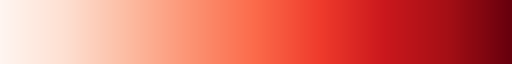

In [61]:
colormap

In [63]:
orig_stations_gdf_single_service[service_to_map]

NameError: name 'orig_stations_gdf_single_service' is not defined

<Axes: title={'center': 'Stations Served by the A Train'}>

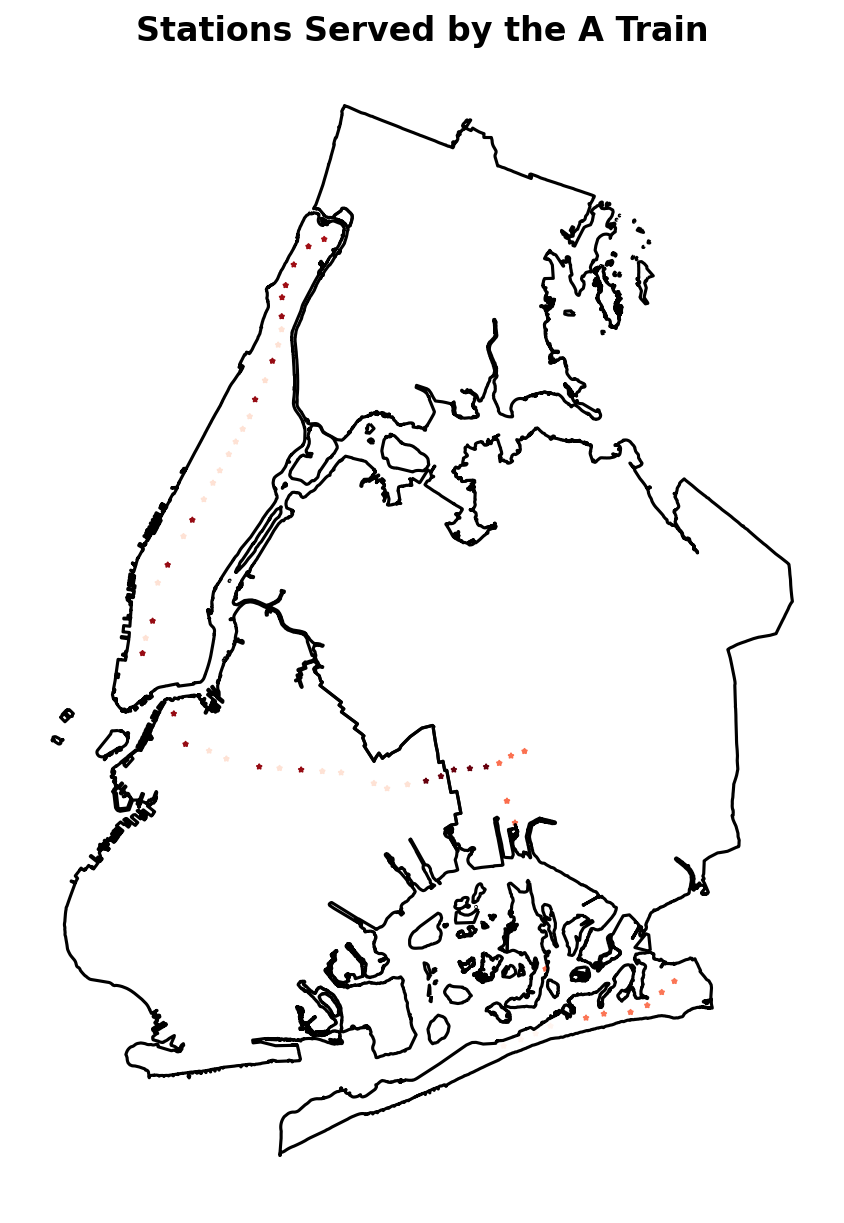

In [65]:
service_to_map = 'A'
orig_stations_gdf_single_service = orig_stations_gdf[orig_stations_gdf[service_to_map]>0]

fig, ax = plt.subplots(figsize=(10,10))
ax.axis('off')
ax.set_title(f"Stations Served by the {service_to_map} Train", color='black', fontsize=16, weight='bold')
boros.boundary.plot(ax=ax, color="black")

vmin, vmax = orig_stations_gdf_single_service[service_to_map].min(), orig_stations_gdf_single_service[service_to_map].max()
vcenter = vmin + 0.01
normalize = mcolors.Normalize(vmin=vmin, vmax=vmax)
colormap = cm.Reds
# stations
# orig_stations_gdf_single_service['geometry'].plot(marker='*', markersize=5, ax=ax, aspect='auto')
orig_stations_gdf_single_service.plot(column=service_to_map, cmap=cm.Reds, norm=normalize, marker='*', markersize=5, ax=ax, )